Spatial interpolation is a technique where regaurly spaced or irregularly spaced data points distributed across a region are used to estimate the value at unsampled points. In this tutorial, we will use Scipy's `LinearNDInterpolator` and `CloughTocher2DInterpolator` functions for approximating soil moisture values at unsampled locations between non-regularly spaced observations. 

The `LinearNDInterpolator` consists of a piece-wise linear interpolation to estimate values at arbitrary locations within the convex hull formed by the input data points.

The `CloughTocher2DInterpolator` uses a triangular interpolation, which provides a smoother and potentially more accurate representation of the data's spatial variation. This method constructs a continuous surface over the input data by fitting quadratic surfaces for each triangle formed by the data points.


In [122]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator


In [123]:
# Define coordiante reference systems
crs_utm = 32614 # UTM Zone 14
crs_wgs = 4326 # WGS84

In [124]:
# Read dataset
df = pd.read_csv('../datasets/spatial/soil_moisture_surveys/kona_15_jul_2019.csv')

# Inspect a few rows
df.head(3)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor
0,7/15/2019 7:15,320,ZONE 00001,39.11060,-96.61089,38.88,1.6988,1.8181,23.8419,CD659 12cm rods,3543
1,7/15/2019 7:17,321,"ZONE 00001, ZONE 00011",39.11058,-96.61116,41.71,1.7474,1.8310,26.7794,CD659 12cm rods,3543
2,7/15/2019 7:17,322,"ZONE 00001, ZONE 00011",39.11055,-96.61146,40.59,1.7271,1.7911,25.5712,CD659 12cm rods,3543


In [125]:
# Drop lines with NaN in 'Moisture' column
df.dropna(subset='Moisture', inplace=True)
df.reset_index(drop=True, inplace=True)


In [126]:
# Convert Dataframe to GeoDataframe
gdf = gpd.GeoDataFrame(df)


In [127]:
# Add Point geometry from lat and long values
gdf['points'] = gpd.points_from_xy(gdf['Longitude'], gdf['Latitude'])
gdf.set_geometry('points', drop=True, inplace=True, crs=crs_wgs)


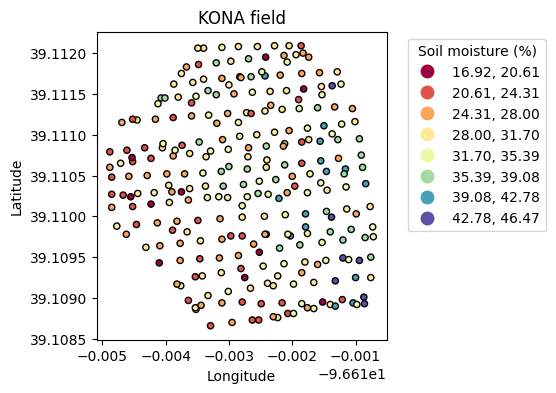

In [128]:
# Inspect spatial data
plt.figure(figsize=(5,4))
plt.title('KONA field')
gdf.plot(ax=plt.gca(), edgecolor='k', marker='.', s=80, column='Moisture',
         cmap='Spectral', scheme='equal_interval', k=8, legend=True,
         legend_kwds={'loc':'upper left',
                      'bbox_to_anchor':(1.05,1),
                      'title':'Soil moisture (%)'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [129]:
# Convert point coordinates to UTM, so that we can work in meters
# to compute distances within the field
gdf.to_crs(crs=crs_utm, inplace=True)


In [130]:
# Get values of longitude (x) and latitude (y) in meters
x = gdf['geometry'].x.values
y = gdf['geometry'].y.values
z = gdf['Moisture'].values

# Create tuple of points
points = (x, y)


In [131]:
# Generate grid
x_vec = np.linspace(x.min(), x.max(), num=100)
y_vec = np.linspace(y.min(), y.max(), num=100)

# Create grid
X_grid, Y_grid = np.meshgrid(x_vec, y_vec)
print(X_grid.shape)


(100, 100)


In [132]:
# Interpolation using LinearNDInterpolator
NDinterp = LinearNDInterpolator(list(zip(x, y)), z)
Z_grid_NDinterp = NDinterp(X_grid, Y_grid)


In [133]:
# Interpolation using CloughTocher
CTinterp = CloughTocher2DInterpolator(list(zip(x, y)), z)
Z_grid_CTinterp = CTinterp(X_grid, Y_grid)


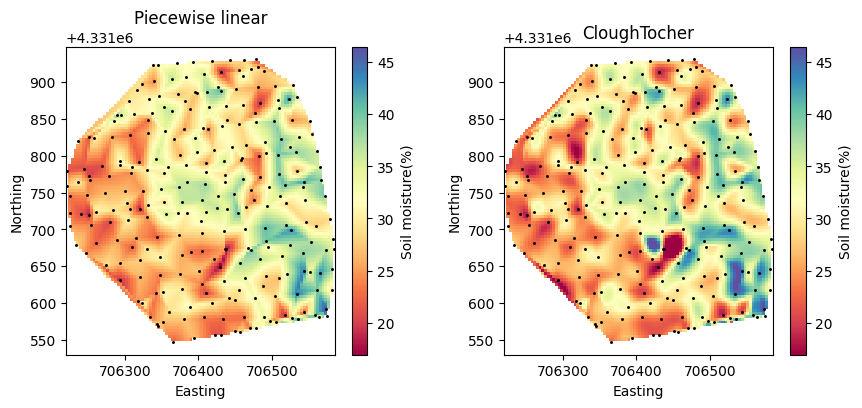

In [135]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Piecewise linear')
p1 = plt.pcolormesh(X_grid, Y_grid, Z_grid_NDinterp, 
               cmap='Spectral', vmin=z.min(), vmax=z.max())
plt.scatter(x, y, color='k', marker='.', s=5)
plt.colorbar(p1, label='Soil moisture(%)')
plt.axis("equal")
plt.xlabel('Easting')
plt.ylabel('Northing')

plt.subplot(1,2,2)
plt.title('CloughTocher')
p2 = plt.pcolormesh(X_grid, Y_grid, Z_grid_CTinterp, 
               cmap='Spectral', vmin=z.min(), vmax=z.max())
plt.scatter(x, y, color='k', marker='.', s=5)
plt.colorbar(p2, label='Soil moisture(%)')
plt.axis("equal")
plt.xlabel('Easting')
plt.ylabel('Northing')

plt.subplots_adjust(wspace=0.3)
plt.show()